# Install Necessary Libraries and Import Modules

In [1]:
!pip install -q tensorflow-recommenders --quiet
!pip install -q --upgrade tensorflow-datasets --quiet

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_recommenders as tfrs
import logging
from keras.saving import register_keras_serializable
from dataclasses import dataclass
from tensorflow.keras.callbacks import EarlyStopping

# Download & Load Dataset

In [3]:
!wget https://raw.githubusercontent.com/AldiraPutri19/Locoveer/refs/heads/machine-learning/datasets/user_ratings.csv --quiet
!wget https://raw.githubusercontent.com/AldiraPutri19/Locoveer/refs/heads/machine-learning/datasets/travel_destinations.csv --quiet
!wget https://raw.githubusercontent.com/AldiraPutri19/Locoveer/refs/heads/machine-learning/datasets/eco_impact_matrix.csv --quiet

In [4]:
user_ratings_df = pd.read_csv('user_ratings.csv')
travel_destinations_df = pd.read_csv('travel_destinations.csv')
eco_impact_matrix_df = pd.read_csv('eco_impact_matrix.csv')

# Exploration & Preprocessing The Data

## Travel Destinations Dataset

In [5]:
travel_destinations_df.head()

,Destination_ID,Destination_Name,Description,Category,City,Price,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1.0,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1.0
1,2.0,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2.0
2,3.0,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3.0
3,4.0,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4.0
4,5.0,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5.0


In [6]:
travel_destinations_df.isnull().sum()

,0
Destination_ID,0
Destination_Name,0
Description,0
Category,0
City,0
Price,0
Coordinate,0
Lat,3
Long,0
Unnamed: 11,437


In [7]:
travel_destinations_df.shape

(437, 11)

In [8]:
travel_destinations_df.drop(columns=['Description', 'Price', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12'], inplace=True)
travel_destinations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Destination_ID    437 non-null    float64
 1   Destination_Name  437 non-null    object 
 2   Category          437 non-null    object 
 3   City              437 non-null    object 
dtypes: float64(1), object(3)
memory usage: 13.8+ KB


## Eco Impact Matrix Dataset

In [9]:
eco_impact_matrix_df.head()

,Destination_ID,Eco_Friendliness,Renewable_Energy_Usage,Waste_Management,Public_Transport_Access,Cultural_Preservation_Effort
0,1,High,False,Excellent,Low,Strong
1,2,High,False,Good,Moderate,Strong
2,3,Medium,False,Good,High,Strong
3,4,Low,True,Excellent,Moderate,Strong
4,5,Low,True,Poor,Moderate,Moderate


In [10]:
eco_impact_matrix_df.isnull().sum()

,0
Destination_ID,0
Eco_Friendliness,0
Renewable_Energy_Usage,0
Waste_Management,0
Public_Transport_Access,0
Cultural_Preservation_Effort,0


### Mapping Eco Impact Matrix

In [11]:
categorical_mappings = {
    "Eco_Friendliness": {"High": 3, "Medium": 2, "Low": 1},
    "Renewable_Energy_Usage": {True: 1, False: 0},
    "Waste_Management": {"Excellent": 3, "Good": 2, "Poor": 1},
    "Public_Transport_Access": {"High": 3, "Moderate": 2, "Low": 1},
    "Cultural_Preservation_Effort": {"Strong": 3, "Moderate": 2, "Weak": 1}
}

def apply_mappings(data, mappings):
    for column, mapping in mappings.items():
        data[column] = data[column].map(mapping)
    return data

eco_impact_matrix_df = apply_mappings(eco_impact_matrix_df, categorical_mappings)

In [12]:
eco_impact_matrix_df.head()

,Destination_ID,Eco_Friendliness,Renewable_Energy_Usage,Waste_Management,Public_Transport_Access,Cultural_Preservation_Effort
0,1,3,0,3,1,3
1,2,3,0,2,2,3
2,3,2,0,2,3,3
3,4,1,1,3,2,3
4,5,1,1,1,2,2


### Calculating Eco Score

In [13]:
@dataclass
class EcoWeights:
    eco_friendliness: float = -0.4
    renewable_energy_usage: float = -0.4
    waste_management: float = 0.3
    public_transport_access: float = 0.1
    cultural_preservation_effort: float = 0.2

weights = EcoWeights()

In [14]:
def calculate_eco_score(matrix):
    matrix["Eco_Score"] = (
        (matrix["Eco_Friendliness"] * weights.eco_friendliness) +
        (matrix["Renewable_Energy_Usage"] * weights.renewable_energy_usage) +
        (matrix["Waste_Management"] * weights.waste_management) +
        (matrix["Public_Transport_Access"] * weights.public_transport_access) +
        (matrix["Cultural_Preservation_Effort"] * weights.cultural_preservation_effort)
    )

    matrix["Eco_Score"] = (matrix["Eco_Score"] - matrix["Eco_Score"].min()) / (
        matrix["Eco_Score"].max() - matrix["Eco_Score"].min()
    )
    return matrix[["Destination_ID", "Eco_Score"]]

eco_scores = calculate_eco_score(eco_impact_matrix_df)

In [15]:
travel_destinations_df = travel_destinations_df.merge(eco_scores, on='Destination_ID', how='left')

In [16]:
travel_destinations_df.head()

,Destination_ID,Destination_Name,Category,City,Eco_Score
0,1.0,Monumen Nasional,Budaya,Jakarta,0.583333
1,2.0,Kota Tua,Budaya,Jakarta,0.500000
2,3.0,Dunia Fantasi,Taman Hiburan,Jakarta,0.708333
3,4.0,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Jakarta,0.791667
4,5.0,Atlantis Water Adventure,Taman Hiburan,Jakarta,0.458333


## User Ratings Dataset

In [17]:
user_ratings_df.head()

,User_ID,Destination_ID,Rating
0,50,70,5
1,540,71,5
2,602,315,4
3,622,120,4
4,863,268,5


In [18]:
user_ratings_df.isnull().sum()

,0
User_ID,0
Destination_ID,0
Rating,0


In [19]:
user_ratings_df.shape

(100000, 3)

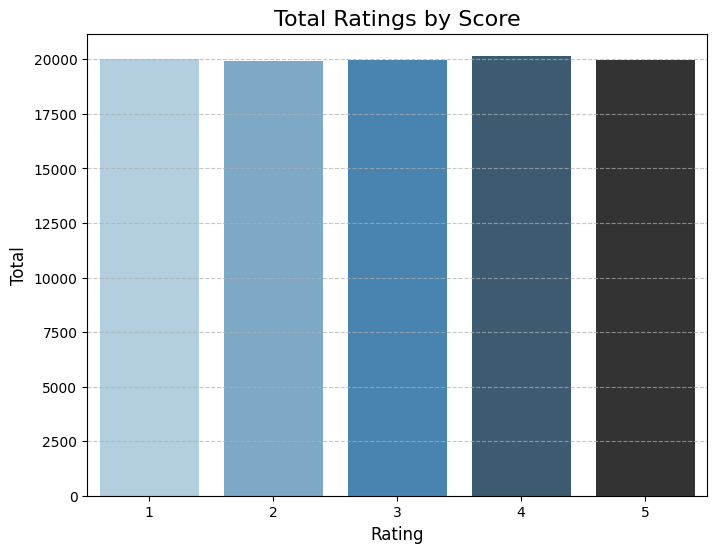

In [20]:
rating_counts = user_ratings_df['Rating'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues_d', hue=rating_counts.index, legend=False)
plt.title('Total Ratings by Score', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Total', fontsize=12)
plt.xticks(ticks=range(len(rating_counts.index)), labels=rating_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
rating_by_destination = user_ratings_df.groupby("Destination_ID").agg({"User_ID": "count", "Rating": "mean"}).reset_index()
rating_by_destination.rename(columns={
    "User_ID": "Number of Ratings",
    "Rating": "Average Rating"
}, inplace=True)

In [22]:
cutoff = 50
top_rated_destinations = rating_by_destination.loc[rating_by_destination["Number of Ratings"] > cutoff].sort_values(by="Average Rating", ascending=False)

In [23]:
userIds = user_ratings_df.User_ID.unique()
destinationIds = user_ratings_df.Destination_ID.unique()

user_mapping = {id_: idx for idx, id_ in enumerate(userIds)}
destination_mapping = {id_: idx for idx, id_ in enumerate(destinationIds)}

In [24]:
def map_ids(column, mapping):
    return column.map(mapping)

user_ratings_df['User_ID'] = map_ids(user_ratings_df['User_ID'], user_mapping)
user_ratings_df['Destination_ID'] = map_ids(user_ratings_df['Destination_ID'], destination_mapping)

In [25]:
user_ratings_df = user_ratings_df.merge(
    travel_destinations_df[['Destination_ID', 'Eco_Score']],
    on='Destination_ID',
    how='left'
)

In [26]:
user_ratings_df.head()

,User_ID,Destination_ID,Rating,Eco_Score
0,0,0,5,NaN
1,1,1,5,0.583333
2,2,2,4,0.500000
3,3,3,4,0.708333
4,4,4,5,0.791667


In [27]:
user_ratings_df.dropna()

,User_ID,Destination_ID,Rating,Eco_Score
1,1,1,5,0.583333
2,2,2,4,0.500000
3,3,3,4,0.708333
4,4,4,5,0.791667
5,5,5,1,0.458333
...,...,...,...,...
99995,312,246,1,0.375000
99996,692,46,3,0.375000
99997,302,305,4,0.833333
99998,411,167,5,0.000000


## Tensorflow Dataset Preparation

In [28]:
ratings = tf.data.Dataset.from_tensor_slices({
    "userId": tf.convert_to_tensor(user_ratings_df.User_ID.astype(str).values, dtype=tf.string),
    "destinationId": tf.convert_to_tensor(user_ratings_df.Destination_ID.astype(str).values, dtype=tf.string),
    "rating": tf.cast(user_ratings_df.Rating.values, tf.float32),
})

## Splitting The Dataset (Train 60%, Validation 20%, Test 20%)

In [29]:
total_ratings = len(user_ratings_df)
train_size = int(0.6 * total_ratings)
val_size = int(0.2 * total_ratings)

shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(train_size)
validation = shuffled.skip(train_size).take(val_size)
test = shuffled.skip(train_size + val_size)

print(f"Train: {train_size}, Validation: {val_size}, Test: {total_ratings - train_size - val_size}")

Train: 60000, Validation: 20000, Test: 20000


## Preprocess The Data

In [30]:
def preprocess_data(data):
    return {
        "userId": data["userId"],
        "destinationId": data["destinationId"]
    }, data["rating"]

train_data = train.map(preprocess_data).batch(128).cache().prefetch(tf.data.AUTOTUNE)
validation_data = validation.map(preprocess_data).batch(128).cache().prefetch(tf.data.AUTOTUNE)
test_data = test.map(preprocess_data).batch(128).cache()

# Building & Training The Model

In [31]:
def create_ranking_model(user_ids, destination_ids, embedding_dimension=128, callbacks=None):
    user_input = tf.keras.layers.Input(shape=(1,), name="userId", dtype=tf.string)
    user_lookup = tf.keras.layers.StringLookup(vocabulary=[str(x) for x in user_ids], mask_token=None)(user_input)
    user_embedding = tf.keras.layers.Embedding(len(user_ids) + 1, embedding_dimension)(user_lookup)

    destination_input = tf.keras.layers.Input(shape=(1,), name="destinationId", dtype=tf.string)
    destination_lookup = tf.keras.layers.StringLookup(vocabulary=[str(x) for x in destination_ids], mask_token=None)(destination_input)
    destination_embedding = tf.keras.layers.Embedding(len(destination_ids) + 1, embedding_dimension)(destination_lookup)

    concatenated = tf.keras.layers.concatenate([user_embedding, destination_embedding], axis=-1)

    dense_layer_1 = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(concatenated)
    dropout_layer_1 = tf.keras.layers.Dropout(0.5)(dense_layer_1)
    dense_layer_2 = tf.keras.layers.Dense(512, activation="relu")(dropout_layer_1)
    dropout_layer_2 = tf.keras.layers.Dropout(0.4)(dense_layer_2)
    dense_layer_3 = tf.keras.layers.Dense(256, activation="relu")(dropout_layer_2)
    dropout_layer_3 = tf.keras.layers.Dropout(0.3)(dense_layer_3)
    dense_layer_4 = tf.keras.layers.Dense(256, activation="relu")(dropout_layer_3)
    dropout_layer_4 = tf.keras.layers.Dropout(0.3)(dense_layer_4)
    dense_layer_5 = tf.keras.layers.Dense(128, activation="relu")(dropout_layer_4)
    dropout_layer_5 = tf.keras.layers.Dropout(0.2)(dense_layer_5)
    output = tf.keras.layers.Dense(1, name="rating")(dropout_layer_5)

    ranking_model = tf.keras.Model(inputs=[user_input, destination_input], outputs=output, name="RankingModel")
    return ranking_model

In [32]:
@register_keras_serializable()
class TravelRecommendationModel(tfrs.models.Model):
    def __init__(self, ranking_model, **kwargs):
        super(TravelRecommendationModel, self).__init__(**kwargs)
        self.ranking_model = ranking_model
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, inputs):
        return self.ranking_model(inputs)

    def compute_loss(self, features, training=False):
        if isinstance(features, tuple):
            features, labels = features
        else:
            labels = features.pop("rating")
        rating_predictions = self.ranking_model(features)
        return self.task(labels=labels, predictions=rating_predictions)

    def get_config(self):
        config = super().get_config()
        config.update({
            "ranking_model": tf.keras.utils.serialize_keras_object(self.ranking_model),
        })
        return config

    @classmethod
    def from_config(cls, config):
        ranking_model = tf.keras.utils.deserialize_keras_object(config.pop("ranking_model"))
        return cls(ranking_model=ranking_model, **config)

In [33]:
embedding_dimension = 256
ranking_model = create_ranking_model(userIds, destinationIds, embedding_dimension)
travel_model = TravelRecommendationModel(ranking_model)

travel_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [34]:
travel_model.summary()

Model: "travel_recommendation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ RankingModel (Functional)            │ (None, 1, 1)                │       1,648,641 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ranking (Ranking)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,648,641 (6.29 MB)

 Trainable params: 1,648,641 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

In [36]:
history = travel_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=early_stopping
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 2.1468 - regularization_loss: 0.5257 - root_mean_squared_error: 1.5851 - total_loss: 2.6724 - val_loss: 2.3915 - val_regularization_loss: 0.0081 - val_root_mean_squared_error: 1.4119 - val_total_loss: 2.3996
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 2.0240 - regularization_loss: 0.0029 - root_mean_squared_error: 1.4211 - total_loss: 2.0270 - val_loss: 2.3076 - val_regularization_loss: 0.0015 - val_root_mean_squared_error: 1.4127 - val_total_loss: 2.3091
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.0199 - regularization_loss: 0.0013 - root_mean_squared_error: 1.4199 - total_loss: 2.0212 - val_loss: 2.2957 - val_regularization_loss: 9.3109e-04 - val_root_mean_squared_error: 1.4138 - val_total_loss: 2.2966
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 2.0186 - regularization_loss: 5.3057e-04 - root_mean_squared_error: 1.4185 - total_loss: 2.0191 - val_loss: 2.2745 - val_regul

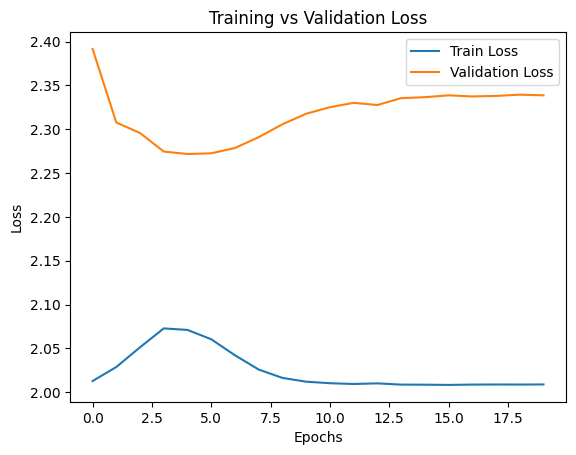

In [37]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Evaluation & Save The Model

In [38]:
test_results = travel_model.evaluate(test_data, return_dict=True)

logging.basicConfig(level=logging.INFO)
logging.info(f"Test Results: {test_results}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0412 - regularization_loss: 3.9139e-04 - root_mean_squared_error: 1.4285 - total_loss: 2.0416


In [39]:
inputs = {
    "userId": tf.keras.layers.Input(name="userId", shape=(), dtype=tf.string),
    "destinationId": tf.keras.layers.Input(name="destinationId", shape=(), dtype=tf.string),
}
outputs = travel_model(inputs)
wrapped_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [40]:
wrapped_model.save('collaborative_filtering_recommendation_system.keras')

from google.colab import files
files.download('collaborative_filtering_recommendation_system.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generate Travel Recommendations

In [41]:
def generate_recommendations(model, user_id, destination_ids, user_mapping, travel_destination, top_n=10, rating_weight=0.6, eco_weight=0.4):
    test_rating = {}

    for dest_id in destination_ids:
        avg_rating = model.ranking_model(
            {"userId": tf.convert_to_tensor([str(user_id)], dtype=tf.string),
             "destinationId": tf.convert_to_tensor([str(dest_id)], dtype=tf.string)}
        )
        eco_score = travel_destination.loc[travel_destination['Destination_ID'] == dest_id, 'Eco_Score'].iloc[0]

        combined_score = (avg_rating.numpy()[0][0] * rating_weight) + (eco_score * eco_weight)
        test_rating[dest_id] = {
            "avg_rating": avg_rating.numpy()[0][0],
            "eco_score": eco_score,
            "combined_score": combined_score
        }

    top_destinations = sorted(test_rating, key=lambda x: test_rating[x]["combined_score"], reverse=True)[:top_n]

    recommendations = []
    for dest_id in top_destinations:
        dest_name = travel_destination.loc[travel_destination['Destination_ID'] == dest_id, 'Destination_Name'].iloc[0]
        rating_info = test_rating[dest_id]
        recommendations.append({
            "Destination Name": dest_name,
            "Rating": rating_info["avg_rating"],
            "Eco Score": rating_info["eco_score"],
            "Combined Score": rating_info["combined_score"]
        })

    return recommendations

user_rand = userIds[123]

recommendations = generate_recommendations(travel_model, user_rand, destinationIds, user_mapping, travel_destinations_df, top_n=10)

print(f"Top 10 recommended travel destinations for User {user_rand}:")
for recommendation in recommendations:
    print(f"Destination: {recommendation['Destination Name']} | "
          f"Rating: {recommendation['Rating']} | "
          f"Eco Score: {recommendation['Eco Score']} | "
          f"Combined Score: {recommendation['Combined Score']}")

Top 10 recommended travel destinations for User 181:
Destination: Kiara Artha Park | Rating: [3.1935468] | Eco Score: 1.0 | Combined Score: [2.3161283]
Destination: Taman Pandanaran | Rating: [3.1963832] | Eco Score: 0.9583333333333333 | Combined Score: [2.3011632]
Destination: Klenteng Jin De Yuan | Rating: [3.1957228] | Eco Score: 0.9583333333333333 | Combined Score: [2.300767]
Destination: Museum Taman Prasasti | Rating: [3.2098417] | Eco Score: 0.9166666666666667 | Combined Score: [2.2925718]
Destination: Tebing Breksi | Rating: [3.1969738] | Eco Score: 0.9166666666666667 | Combined Score: [2.284851]
Destination: Wisata Lereng Kelir | Rating: [3.1920753] | Eco Score: 0.9166666666666667 | Combined Score: [2.2819118]
Destination: Wisata Kaliurang | Rating: [3.1833794] | Eco Score: 0.9166666666666667 | Combined Score: [2.2766943]
Destination: Monumen Selamat Datang | Rating: [3.2004218] | Eco Score: 0.8750000000000001 | Combined Score: [2.2702532]
Destination: Pantai Ria Kenjeran | Ra